## MoViNet (Mobile Video Networks) for Video-Based Action Recognition on Kinetics 600 Dataset

### Setup

In [1]:
import os

In [2]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore') 

In [3]:
# Importing libraries
import pathlib
import matplotlib as mpl
import matplotlib.pyplot as plt
import mediapy as media
import numpy as np
import PIL
import tensorflow as tf
import tensorflow_hub as hub
import tqdm

mpl.rcParams.update({
    'font.size': 10,
})

In [4]:
# Getting the kinetics 600 label list, and printing the first few labels
labels_path = tf.keras.utils.get_file(
    fname='labels.txt',
    origin='https://raw.githubusercontent.com/tensorflow/models/f8af2291cced43fc9f1d9b41ddbf772ae7b0d7d2/official/projects/movinet/files/kinetics_600_labels.txt'
)
labels_path = pathlib.Path(labels_path)

lines = labels_path.read_text().splitlines()
KINETICS_600_LABELS = np.array([line.strip() for line in lines])
KINETICS_600_LABELS[:20]

array(['abseiling', 'acting in play', 'adjusting glasses', 'air drumming',
       'alligator wrestling', 'answering questions', 'applauding',
       'applying cream', 'archaeological excavation', 'archery',
       'arguing', 'arm wrestling', 'arranging flowers',
       'assembling bicycle', 'assembling computer',
       'attending conference', 'auctioning', 'backflip (human)',
       'baking cookies', 'bandaging'], dtype='<U49')

We may load a short gif of a person performing jumping jacks to serve as a straightforward example video for categorization.

In [5]:
# Downloading the gif
jumpingjack_url = 'https://github.com/tensorflow/models/raw/f8af2291cced43fc9f1d9b41ddbf772ae7b0d7d2/official/projects/movinet/files/jumpingjack.gif'
jumpingjack_path = tf.keras.utils.get_file(
    fname='jumpingjack.gif',
    origin=jumpingjack_url,
    cache_dir='.', cache_subdir='.',
)

Creating a method that can read a gif file into a tf.Tensor

In [6]:
# Reading and processing a video
def load_gif(file_path, image_size=(224, 224)):
    """Loads a gif file into a TF tensor.

  Use images resized to match what's expected by your model.
  The model pages say the "A2" models expect 224 x 224 images at 5 fps

  Args:
    file_path: path to the location of a gif file.
    image_size: a tuple of target size.

  Returns:
    a video of the gif file
  """
    # Loading a gif file, converting it to a TF tensor
    raw = tf.io.read_file(file_path)
    video = tf.io.decode_gif(raw)
    # Resizing the video
    video = tf.image.resize(video, image_size)
    # changing dtype to a float32
    # Hub models always want images normalized to [0,1]
    video = tf.cast(video, tf.float32) / 255.
    return video

The video's shape is (frames, height, width, colors)

In [7]:
# Returning the shape of the video
jumpingjack=load_gif(jumpingjack_path)
jumpingjack.shape

TensorShape([13, 224, 224, 3])

## Using the model from TensorFlow Hub

Each model has a base and a streaming version.
The base version accepts a video as an input and outputs the probabilities averaged across the frames.
The predictions for that frame are returned together with the new RNN state in the streaming version, which accepts a video frame and an RNN state as input.

### The base model

In [8]:
%%time
id = 'a2'
mode = 'base'
version = '3'
hub_url = f'https://tfhub.dev/tensorflow/movinet/{id}/{mode}/kinetics-600/classification/{version}'
model = hub.load(hub_url)

CPU times: total: 41.4 s
Wall time: 41.6 s


This version of the model has one signature. It takes an image argument which is a tf.float32 with shape (batch, frames, height, width, colors). It returns a dictionary containing one output: A tf.float32 tensor of logits with shape (batch, classes).

In [9]:
sig = model.signatures['serving_default']
print(sig.pretty_printed_signature())

signature_wrapper(*, image)
  Args:
    image: float32 Tensor, shape=(None, None, None, None, 3)
  Returns:
    {'classifier_head': <1>}
      <1>: float32 Tensor, shape=(None, 600)


To run this signature on the video the outer batch dimension to the video should be added first

In [10]:
#warmup
sig(image = jumpingjack[tf.newaxis, :1]);

In [11]:
%%time
logits = sig(image = jumpingjack[tf.newaxis, ...])
logits = logits['classifier_head'][0]

print(logits.shape)
print()

(600,)

CPU times: total: 2min 3s
Wall time: 54.9 s


Defining a get_top_k method that packages the above output processing for later

In [12]:
# Getting top_k labels and probabilities
def get_top_k(probs, k=5, label_map=KINETICS_600_LABELS):
    """Outputs the top k model labels and probabilities on the given video.

    Args:
    probs: probability tensor of shape (num_frames, num_classes) that represents
    the probability of each class on each frame.
    k: the number of top predictions to select.
    label_map: a list of labels to map logit indices to label strings.

    Returns:
    a tuple of the top-k labels and probabilities.
    """
    # Sorting predictions to find top_k
    top_predictions = tf.argsort(probs, axis=-1, direction='DESCENDING')[:k]
    # collecting the labels of top_k predictions
    top_labels = tf.gather(label_map, top_predictions, axis=-1)
    # decoding labels
    top_labels = [label.decode('utf8') for label in top_labels.numpy()]
    # top_k probabilities of the predictions
    top_probs = tf.gather(probs, top_predictions, axis=-1).numpy()
    return tuple(zip(top_labels, top_probs))

Converting the logits to probabilities, and look up the top 5 classes for the video. The model confirms that the video is probably of jumping jacks

In [13]:
probs = tf.nn.softmax(logits, axis=-1)
for label, p in get_top_k(probs):
    print(f'{label:20s}: {p:.3f}')

jumping jacks       : 0.834
zumba               : 0.008
lunge               : 0.003
doing aerobics      : 0.003
polishing metal     : 0.002


### The streaming model


The previous section used a model that runs over a whole video. Often when processing a video we don't want a single prediction at the end, we want to update predictions frame by frame. The stream versions of the model allows us to do this.

In [14]:
%%time
id = 'a2'
mode = 'stream'
version = '3'
hub_url = f'https://tfhub.dev/tensorflow/movinet/{id}/{mode}/kinetics-600/classification/{version}'
model = hub.load(hub_url)

CPU times: total: 2min 12s
Wall time: 2min 12s


Using this model is slightly more complex than the base model as the internal state of the model's RNNs should be kept in track

In [15]:
list(model.signatures.keys())

['call', 'init_states']

The init_states signature takes the video's shape (batch, frames, height, width, colors) as input, and returns a large dictionary of tensors containing the initial RNN states:

In [16]:
lines = model.signatures['init_states'].pretty_printed_signature().splitlines()
lines = lines[:10]
lines.append('      ...')
print('.\n'.join(lines))

signature_wrapper(*, input_shape).
  Args:.
    input_shape: int32 Tensor, shape=(5,).
  Returns:.
    {'state/b0/l0/pool_buffer': <1>, 'state/b0/l0/pool_frame_count': <2>, 'state/b0/l1/pool_buffer': <3>, 'state/b0/l1/pool_frame_count': <4>, 'state/b0/l1/stream_buffer': <5>, 'state/b0/l2/pool_buffer': <6>, 'state/b0/l2/pool_frame_count': <7>, 'state/b0/l2/stream_buffer': <8>, 'state/b1/l0/pool_buffer': <9>, 'state/b1/l0/pool_frame_count': <10>, 'state/b1/l0/stream_buffer': <11>, 'state/b1/l1/pool_buffer': <12>, 'state/b1/l1/pool_frame_count': <13>, 'state/b1/l1/stream_buffer': <14>, 'state/b1/l2/pool_buffer': <15>, 'state/b1/l2/pool_frame_count': <16>, 'state/b1/l2/stream_buffer': <17>, 'state/b1/l3/pool_buffer': <18>, 'state/b1/l3/pool_frame_count': <19>, 'state/b1/l3/stream_buffer': <20>, 'state/b1/l4/pool_buffer': <21>, 'state/b1/l4/pool_frame_count': <22>, 'state/b1/l4/stream_buffer': <23>, 'state/b2/l0/pool_buffer': <24>, 'state/b2/l0/pool_frame_count': <25>, 'state/b2/l0/stream_b

In [17]:
initial_state = model.init_states(jumpingjack[tf.newaxis, ...].shape)

In [18]:
type(initial_state)

dict

In [19]:
list(sorted(initial_state.keys()))[:5]

['state/b0/l0/pool_buffer',
 'state/b0/l0/pool_frame_count',
 'state/b0/l1/pool_buffer',
 'state/b0/l1/pool_frame_count',
 'state/b0/l1/stream_buffer']

Once the initial state for the RNNs is ready,  the state and a video frame can be passed as input (keeping the (batch, frames, height, width, colors) shape for the video frame). The model returns a (logits, state) pair. After just seeing the first frame, the model is not convinced that the video is of "jumping jacks":

In [20]:
inputs = initial_state.copy()

# Add the batch axis, take the first frme, but keep the frame-axis.
inputs['image'] = jumpingjack[tf.newaxis, 0:1, ...]

In [21]:
# warmup
model(inputs);

In [22]:
logits, new_state = model(inputs)
logits = logits[0]
probs = tf.nn.softmax(logits, axis=-1)

for label, p in get_top_k(probs):
    print(f'{label:20s}: {p:.3f}')

print()

golf chipping       : 0.427
tackling            : 0.134
lunge               : 0.056
stretching arm      : 0.053
passing american football (not in game): 0.039



If the model is run in a loop, passing the updated state with each frame, the model quickly converges to the correct result:

In [23]:
%%time
state = initial_state.copy()
all_logits = []

for n in range(len(jumpingjack)):
    inputs = state
    inputs['image'] = jumpingjack[tf.newaxis, n:n+1, ...]
    result, state = model(inputs)
    all_logits.append(logits)

probabilities = tf.nn.softmax(all_logits, axis=-1)

CPU times: total: 4.77 s
Wall time: 1.57 s


In [24]:
for label, p in get_top_k(probabilities[-1]):
    print(f'{label:20s}: {p:.3f}')

golf chipping       : 0.427
tackling            : 0.134
lunge               : 0.056
stretching arm      : 0.053
passing american football (not in game): 0.039


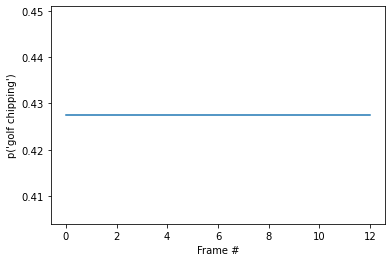

In [25]:
id = tf.argmax(probabilities[-1])
plt.plot(probabilities[:, id])
plt.xlabel('Frame #')
plt.ylabel(f"p('{KINETICS_600_LABELS[id]}')");

The final probability is much more certain than in the previous section where base model is run. The base model returns an average of the predictions over the frames.

In [26]:
for label, p in get_top_k(tf.reduce_mean(probabilities, axis=0)):
    print(f'{label:20s}: {p:.3f}')

golf chipping       : 0.427
tackling            : 0.134
lunge               : 0.056
stretching arm      : 0.053
passing american football (not in game): 0.039


## Animating the predictions over time

The above code was about using the models. This below section builds on top of that to produce some nice inference animations. 

In [27]:
# Defining helper method
# Getting top_k labels and probabilities predicted using MoViNets streaming model
def get_top_k_streaming_labels(probs, k=5, label_map=KINETICS_600_LABELS):
    """Returns the top-k labels over an entire video sequence.

    Args:
    probs: probability tensor of shape (num_frames, num_classes) that represents
      the probability of each class on each frame.
    k: the number of top predictions to select.
    label_map: a list of labels to map logit indices to label strings.

    Returns:
    a tuple of the top-k probabilities, labels, and logit indices
  """
    top_categories_last = tf.argsort(probs, -1, 'DESCENDING')[-1, :1]
    # Sorting predictions to find top_k
    categories = tf.argsort(probs, -1, 'DESCENDING')[:, :k]
    categories = tf.reshape(categories, [-1])

    counts = sorted([
      (i.numpy(), tf.reduce_sum(tf.cast(categories == i, tf.int32)).numpy())
      for i in tf.unique(categories)[0]
  ], key=lambda x: x[1], reverse=True)

    top_probs_idx = tf.constant([i for i, _ in counts[:k]])
    top_probs_idx = tf.concat([top_categories_last, top_probs_idx], 0)
    # finding unique indices of categories
    top_probs_idx = tf.unique(top_probs_idx)[0][:k+1]
    # top_k probabilities of the predictions
    top_probs = tf.gather(probs, top_probs_idx, axis=-1)
    top_probs = tf.transpose(top_probs, perm=(1, 0))
     # collecting the labels of top_k predictions
    top_labels = tf.gather(label_map, top_probs_idx, axis=0)
    # decoding the top_k labels
    top_labels = [label.decode('utf8') for label in top_labels.numpy()]

    return top_probs, top_labels, top_probs_idx

# Plotting top_k predictions at a given time step
def plot_streaming_top_preds_at_step(
    top_probs,
    top_labels,
    step=None,
    image=None,
    legend_loc='lower left',
    duration_seconds=10,
    figure_height=500,
    playhead_scale=0.8,
    grid_alpha=0.3):
    """Generates a plot of the top video model predictions at a given time step.

  Args:
    top_probs: a tensor of shape (k, num_frames) representing the top-k
      probabilities over all frames.
    top_labels: a list of length k that represents the top-k label strings.
    step: the current time step in the range [0, num_frames].
    image: the image frame to display at the current time step.
    legend_loc: the placement location of the legend.
    duration_seconds: the total duration of the video.
    figure_height: the output figure height.
    playhead_scale: scale value for the playhead.
    grid_alpha: alpha value for the gridlines.

  Returns:
    A tuple of the output numpy image, figure, and axes.
  """
    # finding number of top_k labels and frames in the video
    num_labels, num_frames = top_probs.shape
    if step is None:
        step = num_frames
    # Visualizing frames and top_k probabilities of streaming video
    fig = plt.figure(figsize=(6.5, 7), dpi=300)
    gs = mpl.gridspec.GridSpec(8, 1)
    ax2 = plt.subplot(gs[:-3, :])
    ax = plt.subplot(gs[-3:, :])
    # displaying the frame
    if image is not None:
        ax2.imshow(image, interpolation='nearest')
        ax2.axis('off')
    # x-axis (frame number)
    preview_line_x = tf.linspace(0., duration_seconds, num_frames)
    # y-axis (top_k probabilities)
    preview_line_y = top_probs

    line_x = preview_line_x[:step+1]
    line_y = preview_line_y[:, :step+1]

    for i in range(num_labels):
        ax.plot(preview_line_x, preview_line_y[i], label=None, linewidth='1.5',
            linestyle=':', color='gray')
        ax.plot(line_x, line_y[i], label=top_labels[i], linewidth='2.0')


    ax.grid(which='major', linestyle=':', linewidth='1.0', alpha=grid_alpha)
    ax.grid(which='minor', linestyle=':', linewidth='0.5', alpha=grid_alpha)

    min_height = tf.reduce_min(top_probs) * playhead_scale
    max_height = tf.reduce_max(top_probs)
    ax.vlines(preview_line_x[step], min_height, max_height, colors='red')
    ax.scatter(preview_line_x[step], max_height, color='red')

    ax.legend(loc=legend_loc)

    plt.xlim(0, duration_seconds)
    plt.ylabel('Probability')
    plt.xlabel('Time (s)')
    plt.yscale('log')

    fig.tight_layout()
    fig.canvas.draw()

    data = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    data = data.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    plt.close()

    figure_width = int(figure_height * data.shape[1] / data.shape[0])
    image = PIL.Image.fromarray(data).resize([figure_width, figure_height])
    image = np.array(image)

    return image

# Plotting top_k predictions from MoViNets streaming model
def plot_streaming_top_preds(
    probs,
    video,
    top_k=5,
    video_fps=25.,
    figure_height=500,
    use_progbar=True):
    """Generates a video plot of the top video model predictions.

    Args:
    probs: probability tensor of shape (num_frames, num_classes) that represents
      the probability of each class on each frame.
    video: the video to display in the plot.
    top_k: the number of top predictions to select.
    video_fps: the input video fps.
    figure_fps: the output video fps.
    figure_height: the height of the output video.
    use_progbar: display a progress bar.

  Returns:
    A numpy array representing the output video.
  """
    # selecting number of frames per second
    video_fps = 8.
    # selecting height of the image
    figure_height = 500
    # number of time steps of the given video
    steps = video.shape[0]
    # estimating duration of the video (in seconds)
    duration = steps / video_fps
    # estiamting top_k probabilities and corresponding labels
    top_probs, top_labels, _ = get_top_k_streaming_labels(probs, k=top_k)

    images = []
    step_generator = tqdm.trange(steps) if use_progbar else range(steps)
    for i in step_generator:
        image = plot_streaming_top_preds_at_step(
          top_probs=top_probs,
          top_labels=top_labels,
          step=i,
          image=video[i],
          duration_seconds=duration,
          figure_height=figure_height,
    )
        images.append(image)

    return np.array(images)

In [28]:
# Running the streaming model across the frames of the video, and collecting the logits
init_states = model.init_states(jumpingjack[tf.newaxis].shape)

In [29]:
# Inserting the video clip here
video = jumpingjack
images = tf.split(video[tf.newaxis], video.shape[0], axis=1)

all_logits = []

# To run on a video, passing in one frame at a time
states = init_states
for image in tqdm.tqdm(images):
    # predictions for each frame
    logits, states = model({**states, 'image': image})
    all_logits.append(logits)

# concatinating all the logits
logits = tf.concat(all_logits, 0)
# estimating probabilities
probs = tf.nn.softmax(logits, axis=-1)

100%|██████████| 13/13 [00:01<00:00,  8.16it/s]


In [30]:
final_probs = probs[-1]
print('Top_k predictions and their probablities\n')
for label, p in get_top_k(final_probs):
    print(f'{label:20s}: {p:.3f}')

Top_k predictions and their probablities

jumping jacks       : 0.999
zumba               : 0.000
doing aerobics      : 0.000
dancing charleston  : 0.000
slacklining         : 0.000


Converting the sequence of probabilities into a video

In [31]:
# Generating a plot and output to a video tensor
plot_video = plot_streaming_top_preds(probs, video, video_fps=8.)

100%|██████████| 13/13 [00:14<00:00,  1.08s/it]


In [32]:
# For gif format, setting codec='gif'
media.show_video(plot_video, fps=3)